Import Libary

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Load Dataset

In [184]:
# Load dataset
file_path = 'new_model.csv'
data = pd.read_csv(file_path)
data.head()

,Bp,Sg,Al,Su,Rbc,Bu,Sc,Sod,Pot,Hemo,Wbcc,Rbcc,Htn,Class
0,80.0,1.020,1.0,0.0,1.0,36.0,1.2,137.53,4.63,15.4,7800.0,5.20,1.0,1
1,50.0,1.020,4.0,0.0,1.0,18.0,0.8,137.53,4.63,11.3,6000.0,4.71,0.0,1
2,80.0,1.010,2.0,3.0,1.0,53.0,1.8,137.53,4.63,9.6,7500.0,4.71,0.0,1
3,70.0,1.005,4.0,0.0,1.0,56.0,3.8,111.00,2.50,11.2,6700.0,3.90,1.0,1
4,80.0,1.010,2.0,0.0,1.0,26.0,1.4,137.53,4.63,11.6,7300.0,4.60,0.0,1


Preprocessing

In [185]:
#Data Preprocessing
# Mengisi nilai hilang numerik dengan mean
data.fillna(data.mean(), inplace=True)
# Mengisi nilai hilang kategorikal dengan modus
for col in data.select_dtypes(include=['object']).columns:
    data[col].fillna(data[col].mode()[0], inplace=True)


In [186]:
# Normalisasi hanya untuk kolom numerik
data_numeric = data.select_dtypes(include=['int64', 'float64'])
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_numeric), columns=data_numeric.columns)
# Mengganti kolom asli dengan yang telah dinormalisasi
data[data_numeric.columns] = data_scaled

In [187]:
# One-Hot Encoding untuk kolom kategorikal
encoder = OneHotEncoder(sparse_output=False, drop='first')
data_categorical = data.select_dtypes(include=['object'])
encoded_data = pd.DataFrame(encoder.fit_transform(data_categorical), columns=encoder.get_feature_names_out(data_categorical.columns))
# Menggabungkan kembali ke dataset utama
data = pd.concat([data.reset_index(drop=True), encoded_data.reset_index(drop=True)], axis=1)
# Menghapus kolom kategorikal asli
data.drop(columns=data_categorical.columns, inplace=True)

In [188]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
data_cleaned = data[~outliers]

EDA

In [189]:
#EDA
# Summary statistics
summary_stats = data.describe()

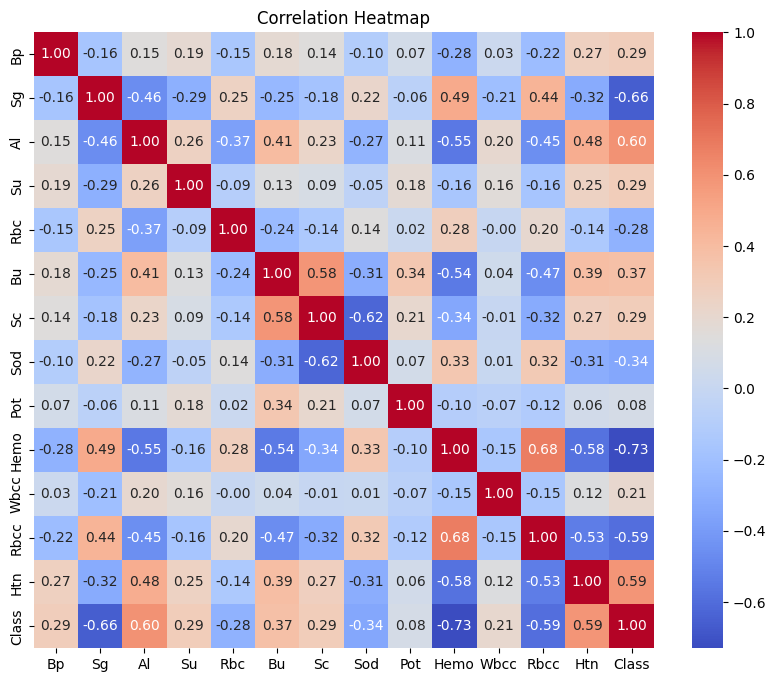

In [190]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

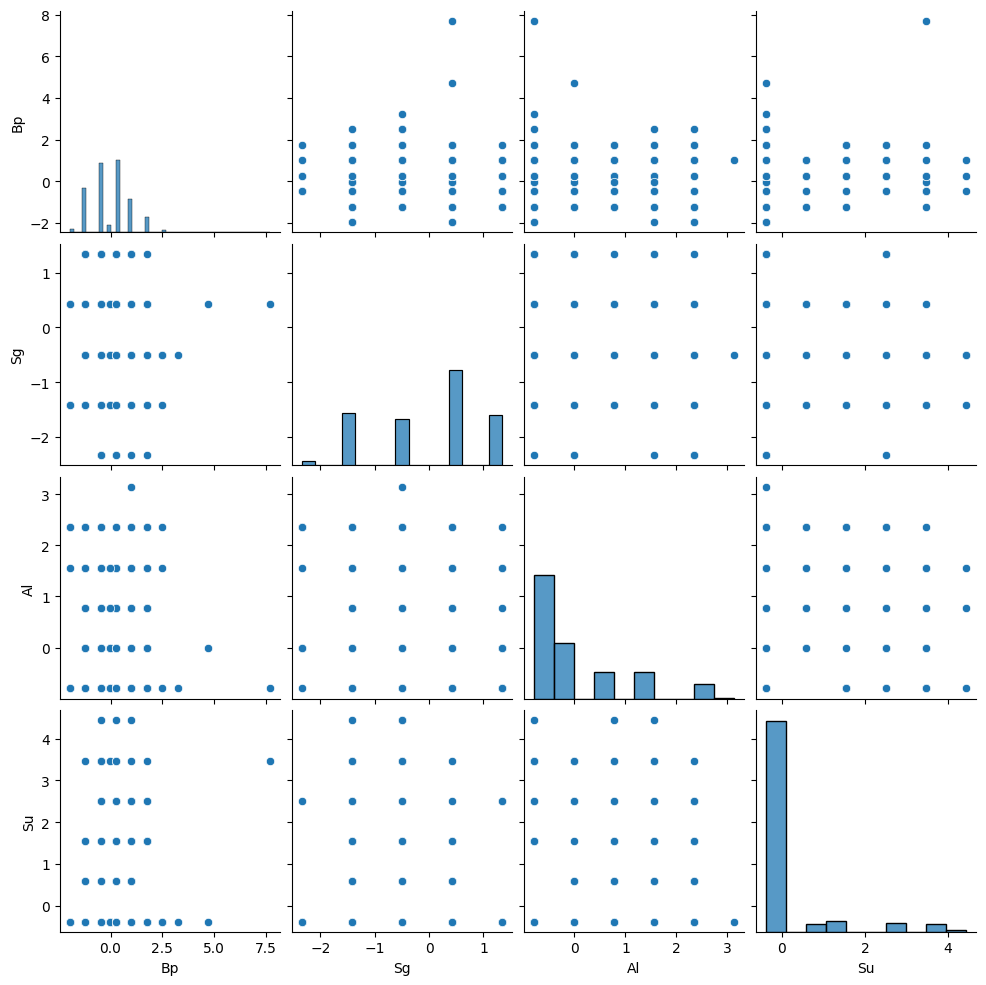

In [191]:
# Pairplot for visual relationships (limited to 4 numerical features for simplicity)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns[:4]
sns.pairplot(data[numerical_columns])
plt.show()

In [213]:
if 'Bp' in data_cleaned.columns:
    X = data_cleaned.drop(columns=['Bp'])
    y = data_cleaned['Bp']
     # Mengubah target menjadi kategori berdasarkan median
    y = pd.cut(y, bins=[-float('inf'), y.median(), float('inf')], labels=[0, 1])
else:
    raise ValueError("Kolom 'bp' tidak ditemukan dalam dataset. Pastikan kolom target sudah ada dalam dataset Anda.")


In [214]:

# Seleksi Fitur
# Menggunakan SelectKBest dengan ANOVA F-test untuk seleksi fitur terbaik
selector = SelectKBest(score_func=f_classif, k=10)  # Pilih 10 fitur terbaik
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Fitur yang dipilih:", selected_features.tolist())



Fitur yang dipilih: ['Sg', 'Al', 'Su', 'Bu', 'Sod', 'Hemo', 'Wbcc', 'Rbcc', 'Htn', 'Class']


Modeling

In [215]:
# Memperbarui X dengan fitur terpilih
X = pd.DataFrame(X_selected, columns=selected_features)

In [216]:
# Membagi dataset setelah seleksi fitur
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [217]:
# Dataset siap digunakan
print(f"Data setelah preprocessing dan seleksi fitur memiliki {X_train.shape[0]} baris untuk training dan {X_test.shape[0]} baris untuk testing.")

Data setelah preprocessing dan seleksi fitur memiliki 170 baris untuk training dan 43 baris untuk testing.


In [223]:
# Pembuatan Model Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)


LogisticRegression()

In [228]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Evaluasi Model

In [224]:
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Akurasi Logistic Regression:", accuracy_lr)
print("\nLaporan Klasifikasi Logistic Regression:\n", classification_report(y_test, y_pred_lr))

Akurasi Logistic Regression: 0.5581395348837209

Laporan Klasifikasi Logistic Regression:
               precision    recall  f1-score   support

           0       0.73      0.55      0.63        29
           1       0.38      0.57      0.46        14

    accuracy                           0.56        43
   macro avg       0.55      0.56      0.54        43
weighted avg       0.61      0.56      0.57        43



In [229]:
# Evaluasi Model Random Forest
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Akurasi Random Forest:", accuracy_rf)
print("\nLaporan Klasifikasi Random Forest:\n", classification_report(y_test, y_pred_rf))

Akurasi Random Forest: 0.46511627906976744

Laporan Klasifikasi Random Forest:
               precision    recall  f1-score   support

           0       0.67      0.41      0.51        29
           1       0.32      0.57      0.41        14

    accuracy                           0.47        43
   macro avg       0.49      0.49      0.46        43
weighted avg       0.55      0.47      0.48        43

